TP1 - Recalage d'images
=============

In [25]:
import numpy as np
import numpy.linalg as npl
from scipy import signal
from scipy import interpolate
from PIL import Image
import matplotlib.pyplot as plt
import cv2


Un problème fréquemment rencontré dans le domaine du traitement d’images est celui du recalage. On dispose de plusieurs images prises à des temps différents, ou par des appareils différents, et on aimerait les mettre en correspondence, c’est-à-dire trouver une déformation du plan, qui assure une correspondence point à point des objets sous-jacents. Donnons quelques exemples d’applications :
* Traitements/retouches d’images. Par exemple, on peut vouloir construire un panoramique à partir d’images de petite taille. Il faut les recaler préalablement.
* Evaluation des déplacements d’objets dans des séquences vidéos (e.g. trouver un défaut de fonctionnement d’un organe, caméras de surveillance, design de robots intelligents ou de systèmes de navigation automatiques ...)
* Couplage d’informations. Par exemple, en imagerie médicale, on obtient une information plus riche en utilisant à la fois une radio et une angiographie. L’une apporte des informations structurelles, l’autre des informations fonctionnelles. Le couplage des deux images donne plus d’information au praticien.
* Beaucoup d’autres applications...

Dans ce TP, nous allons proposer un modèle de recalage assez élémentaire. Les idées constitutives se retrouvent cependant dans presque toutes les techniques récentes.

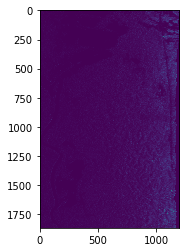

In [3]:
a,b = get_images()
plt.imshow(b)
plt.show()

def get_images() :
    n=21
    sigma=0.3
    [X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,n), indexing='xy')
    Z=np.sqrt(X*X+Y*Y)
    im1=np.zeros((n,n))
    im1[Z<=.7]=1.
    im1[Z<=.3]=.5
    im1[Z<=.1]=.7
    im2=np.zeros((n,n));
    Z=np.sqrt((X-.3)**2+(Y+.2)**2)
    im2[Z<=.7]=1
    im2[Z<=.3]=.5
    im2[Z<=.1]=.7
    G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
    f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
    g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
    f=f/np.max(f)
    g=g/np.max(g)
    return f,g

In [3]:
f,g=get_images()

2.1. Calcul du $E$ et de son gradient
-----------------------------------

Pour pouvoir calculer $E$ et son gradient, on va avoir besoin d'évaluer $f\circ (Id+u)$ et $\nabla f\circ(id+u)$. C'est ce que fait la fonciton interpol ci-dessous.

In [4]:
def interpol(f,ux,uy) :
    """function that computes f \circ Id+u and interpolates it on a mesh"""
    nx,ny=f.shape
    ip=interpolate.RectBivariateSpline(np.arange(nx),np.arange(ny),f)
    [X,Y]=np.meshgrid(np.arange(nx),np.arange(ny), indexing='ij')
    X=X+ux
    Y=Y+uy
    return np.reshape(ip.ev(X.ravel(),Y.ravel()),(nx,ny))

In [5]:
def dx(im) :
    d = np.zeros_like(im)
    d[:-1,:] = im[1:,:]-im[:-1,:]
    return d
def dy(im) :
    d = np.zeros_like(im)
    d[:,:-1] = im[:,1:]-im[:,:-1]
    return d
def dxT(im) :
    d = np.zeros_like(im)
    d[0,:] = -im[0,:]
    d[1:-1,:] = im[:-2,:] - im[1:-1,:]
    d[-1,:] = im[-2,:]
    return d
def dyT(im) :
    d = np.zeros_like(im)
    # To be implemented
    d[:,0] = -im[:,0]
    d[:,1:-1] = im[:,:-2] - im[:,1:-1]
    d[:,-1] = im[:,-2]
    return d  

2.3. Implémentation de la fonction objectif $E+R$
----------------------------------------------

In [6]:
def objective_function(f,g,ux,uy,lamb,mu):
    fu = interpol(f, ux, uy)
    
    E = (1/2) * npl.norm(fu - g)**2
        
    R = mu/2 * npl.norm(dx(uy) + dy(ux))**2 + (lamb+mu)/2 * npl.norm(dx(ux) + dy(uy))**2
    
    return E + R,fu

# 3. Un algorithme de gradient

Une itération de la méthode de descente de gradient est de la forme:

$$
u_{k+1}=u_k-s_k(\nabla E(u) + \nabla R(u))
$$

Q5. Compléter la fonction RecalageDG implémentant la descente de gradient et utilisant l'algorithme de recherche linéaire par rebroussement proposé ci-dessous.

In [7]:
def linesearch(ux,uy,step,descentx,descenty,obj_old,f,g,lamb,mu) :
    step=2*step
    tmpx=ux-step*descentx
    tmpy=uy-step*descenty
    obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    while obj >obj_old and step > 1.e-8:
        step=0.5*step
        tmpx=ux-step*descentx
        tmpy=uy-step*descenty
        obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    return tmpx,tmpy,step

In [8]:
def RecalageDG(f,g,lamb,mu,nitermax,stepini=0.1, modulo=5, plot=True) : 
    ux=np.zeros_like(f)
    uy=np.zeros_like(f)  
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    
    dfx = dx(f)
    dfy = dy(f)
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)   
        # Gradient of E at point u
        gradfuX = interpol(dfx, ux, uy)
        gradfuY = interpol(dfy, ux, uy)        
        
        gradEx = (fu - g) * gradfuX
        gradEy = (fu - g) * gradfuY
        
        #fu = interpol(f, ux, uy)
        #gradfuX = dx(fu)
        #gradfuY = dy(fu)
        
        #gradEx = (fu - g) * gradfuX
        #gradEy = (fu - g) * gradfuY
        
        # Gradient of R at point u
        gradRx = mu * (dyT(dy(ux)) + dyT(dx(uy))) + (mu+lamb) * (dxT(dx(ux)) + dxT(dy(uy)))
        gradRy = mu * (dxT(dy(ux)) + dxT(dx(uy))) + (mu+lamb) * (dyT(dx(ux)) + dyT(dy(uy)))
        
        # Gradient of E+R at point u
        gradx = gradEx + gradRx
        grady = gradEy + gradRy
        
        ux,uy,step=linesearch(ux,uy,step,gradx,grady,obj,f,g,lamb,mu)
        step_list.append(step)
        if (plot and niter % modulo ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF), niter

Q5. Ecrire un compte-rendu des expériences réalisées et des résultats obtenus. Commentez.

In [9]:
def find_mins(lamb_range, mu_range, nb_points=10, 
              nitermax=4000, modulo=10, plot=True):
    values_lamb = np.linspace(lamb_range[0], lamb_range[1], nb_points)
    values_mu = np.linspace(mu_range[0], mu_range[1], nb_points)
    
    niters = np.zeros(nb_points)
    CFs = []
    
    step0 = 0.1
    print(values_lamb.shape)
    print(values_mu.shape)
    print(values_lamb[1])
    
    
    for i in range(nb_points):
        ux, uy, CF, step, niters[i] = RecalageDG(f, g, values_lamb[i],
                                                 values_mu[i], nitermax,
                                                 step0, modulo, plot)
        CFs.append(CF)
        
    return values_lamb, values_mu, CFs, niters

In [11]:
def find_plot(lamb_range, mu_range, nb_points=10, nitermax=4000, modulo=10, plot=True):
    lambs, mus, CFs, niters = find_mins(lamb_range, mu_range, nb_points, nitermax, modulo, plot)
    
    plt.figure()
    plt.semilogy(lambs, niters, label="lambs")
    plt.plot()
    
    plt.figure()
    plt.semilogy(mus, niters, label="mus")
    plt.plot()
    
    print(niters)
    print(CFs)

In [ ]:
find_plot([-1, 1.5], [-0.1, 0.15], nb_points=20, nitermax=500, modulo=100, plot=True)

In [27]:
#lamb=10
#mu=20
lamb=0.11
mu=0.011

nitermax=5000

step0 = 0.01
#ux,uy,CF,step=RecalageDG(f,g,lamb,mu,nitermax)

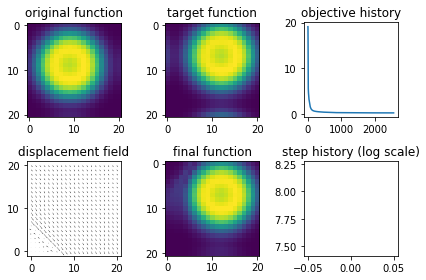

In [22]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

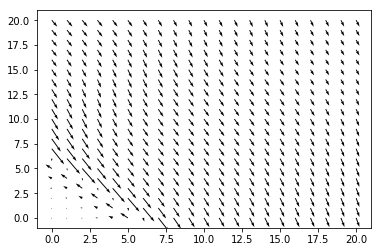

In [23]:
plt.quiver(ux, uy)
plt.show()

L'algorithme de recalage qui utilise la méthode de descente de gradient converge vers la solution en 2500 itérations.


# 4. Algorithme de moindres carrés.

On souhaite maintenant implémenter un algorithme de second ordre pour résoudre le problème $(P)\quad\min_u E(u)+R(u)$ afin d'accélérer la convergence de l'algorithme. Pour cela, on va reformuler le problème $(P)$ en un problème de moindres carrés et appliquer l'algorithme de Levenberg-Marquardt.

Soit:
$$\Psi(u)=\begin{pmatrix} 
f\circ(Id+u)-g \\ 
\sqrt{\mu}(\partial_xu_y+\partial_yu_x) \\ 
\sqrt{\mu+\lambda}(\partial_xu_x+\partial_yu_y) \end{pmatrix},$$
où $f\circ(id+u)$ est l'interpolation de $x\mapsto f(x+u(x))$ sur la grille. Minimiser $E(u)+R(u)$ est équivalent à résoudre le problème suivant:

>$$\min_u \|\Psi(u)\|_2^2.$$

Il s'agit maintenant d'un problème de moindres carrés que l'on va résoudre à l'aide de l'algorithme de Levenberg Marquardt :

$$
u_{k+1}=u_k- H_k^{-1} J_{\Psi}(u_k)^\top \Psi(u_k) \quad\mbox{ avec }\quad H_k=J_{\Psi}(u_k)^\top J_{\Psi}(u_k) +\varepsilon Id
$$

Q6. Calculer la matrice jacobienne de $\Psi$, notée $J_\Psi(u)$.

$$J_\psi(u)=\begin{pmatrix} 
\nabla \Psi_1(u)^\top \\ 
\nabla \Psi_2(u)^\top \\
\nabla \Psi_3(u)^\top
\end{pmatrix}$$
On determine alors les $\nabla \Psi_i(u)$ :
$$\begin{align}
\nabla \Psi_1(u)&=(J_{\Psi_1}(u))^\top \\
J_{\Psi_1}(u)&=J_f(h(u)) \times J_h(u)  \quad  \text{ avec } h(u)=Id+u\\
&=\nabla^\top f(h(u)) \times Id \\
&=\nabla^\top f(h(u)) = \nabla^\top f(Id + u)\\
\nabla _{\Psi_2}(u)&=\sqrt{\mu} \, \nabla (\partial_x u_y + \partial_y u_x)\\
&=\sqrt{\mu} \begin{pmatrix} 
\partial_x  \\
\partial_y  \\
\end{pmatrix}\\
\nabla _{\Psi_3}(u)&=\sqrt{\lambda +\mu} \, \nabla (\partial_x u_x + \partial_y u_y)\\
&=\sqrt{\lambda + \mu} \begin{pmatrix} 
\partial_x  \\
\partial_y  \\
\end{pmatrix}
\end{align}$$

Donc, 
$$\begin{align}
J_{\Psi}(u) \begin{pmatrix}
v_x \\
v_y\\
\end{pmatrix} = \begin{pmatrix}
df_x(Id+u)v_x + df_y (Id+u) v_y \\
\sqrt{\mu}\,\partial _x v_x +\sqrt{\mu}\,\partial_y v_y \\
\sqrt{\lambda + \mu}\,\partial_x v_x + \sqrt{\lambda +\mu}\,\partial_y v_y \\
\end{pmatrix}
\end{align}$$

Q7. Implémenter les fonctions JPsi, JTPsi et JTJ qui calculent respectivement:
- le produit de $J_\psi(u)$ par une direction $v=(v_x,v_y)\in V^2$,

- le produit de $J_\Psi(u)^\top$ par $\phi=(\phi_1,\phi_2,\phi_3)\in V^3$,

- le produit de $(J_\Psi(u)^\top J_\Psi(u)+\epsilon I)$ par une direction $v=(v_x,v_y)\in V^2$.

In [10]:
def JTPsi(phi,df,lamb,mu) :
    ux = df[0]*phi[0] + np.sqrt(mu) * dyT(phi[1]) + np.sqrt(mu + lamb) * dxT(phi[2])
    uy = df[1]*phi[0] + np.sqrt(mu) * dxT(phi[1]) + np.sqrt(mu + lamb) * dyT(phi[2])
    return [ux,uy]
  
def JPsi(vx,vy,df,lamb,mu) :    
    JPsi0 = df[0] * vx + df[1] * vy
    JPsi1 = np.sqrt(mu) * (dy(vx) + dx(vy))
    JPsi2 = np.sqrt(mu + lamb) * (dx(vx) + dy(vy))
    
    return [JPsi0,JPsi1,JPsi2]
  
def JTJ(vx,vy,df,lamb,mu,epsilon) :
    phi = JPsi(vx, vy, df, lamb, mu)
    ux, uy = JTPsi(phi, df, lamb, mu)
    uxs, uys = ux + epsilon*vx, uy + epsilon*vy
    
    return uxs,uys

Calculons maintenant la direction de recherche $d_k$ comme solution du système linéaire:
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = -J_\Psi(u_k)^\top \Psi(u_k)$$
Pour cela, on vous donne l'algorithme suivant qui par la méthode du gradient conjugué calcule une solution $d=(d_x,d_y)\in V^2$ du problème:
$$H_k = (J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = b$$

In [11]:
 def CGSolve(u0x,u0y,lamb,mu,b,epsilon,df) :
    nitmax=100;
    ux=u0x; uy=u0y; #point de départ de l'algorithme
    # Computes JTJu
    Ax,Ay=JTJ(ux,uy,df,lamb,mu,epsilon);
    rx=b[0]-Ax
    ry=b[1]-Ay
    px=rx
    py=ry
    rsold=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
    for i in range(nitmax) :
        Apx,Apy=JTJ(px,py,df,lamb,mu,epsilon);
        alpha=rsold/(np.vdot(rx[:],Apx[:])+np.vdot(ry[:],Apy[:]))
        ux=ux+alpha*px
        uy=uy+alpha*py
        rx=rx-alpha*Apx
        ry=ry-alpha*Apy
        rsnew=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
        if np.sqrt(rsnew)<1e-10 :
            return [ux,uy]
        px=rx+rsnew/rsold*px
        py=ry+rsnew/rsold*py
        rsold=rsnew
    return [ux,uy]

Q8. Compléter l'algorithme RecalageGN implémentant la méthode de Levenberg-Marquardt.

In [48]:
def RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    descentx=np.zeros(f.shape)
    descenty=np.zeros(f.shape)
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    dfx, dfy = dx(f), dy(f)
    df = [dfx, dfy]
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)
        # Gradient of F at point u
        dfxu = interpol(dfx, ux, uy)
        dfyu = interpol(dfy, ux, uy)
        dfu = [dfxu, dfyu]        
        
        psi0 = fu - g        
        psi1 = np.sqrt(mu) * (dx(uy) + dy(ux))
        psi2 = np.sqrt(mu+lamb) * (dx(ux) + dy(uy))
        Psi = [psi0, psi1, psi2]
        b = JTPsi(Psi, dfu, lamb, mu)
          
        #ux, uy = CGSolve(ux, uy, lamb, mu, b, epsi, [dx(f), dy(f)])
        df = [dx(f), dy(f)]
        
        [descentx,descenty]=CGSolve(descentx,descenty,lamb,mu,b,epsi,dfu)
        ux,uy,step=linesearch(ux,uy,step,descentx,descenty,obj,f,g,lamb,mu)
        step_list.append(step)
        # Display
        if (niter % 100 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
            
        if (niter % 500000 ==0):
            fig, ax = plt.subplots(2,3)
            ax[0,0].imshow(f)
            ax[0,0].set_title('original function')
            ax[0,1].imshow(g)
            ax[0,1].set_title('target function')
            ax[1,0].quiver(ux,uy)
            ax[1,0].set_title('displacement field')
            ax[1,1].imshow(interpol(f,ux,uy))
            ax[1,1].set_title('final function')
            ax[0,2].plot(CF)
            ax[0,2].set_title('objective history')
            ax[1,2].plot(np.log(step))
            ax[1,2].set_title('step history (log scale)')

            plt.tight_layout()
            plt.show()
            
    return ux,uy,np.array(CF),np.array(step_list)

In [2]:
def get_images():
    band1 = np.loadtxt("band1.txt")
    band2 = np.loadtxt("band2.txt")
    return band1, band2

In [26]:
def gaussianFilter(im1,factor):
    kernel = np.ones((factor,factor),np.float32)/(factor**2)
    target = cv2.filter2D(im1,-1,kernel)
    return target

In [14]:
b1,b2 = get_images()

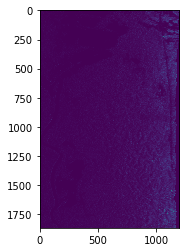

In [18]:
plt.imshow(b2)

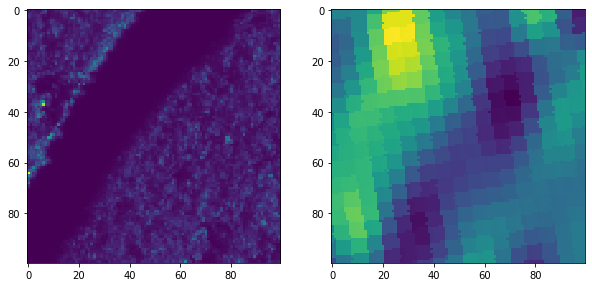

In [67]:
b2_small = np.copy(b2[1000:1100,10:110])
b1_small = np.copy(b1[1000:1100,10:110])

b2_smallf = gaussianFilter(b2_small,1)
b1_smallf = gaussianFilter(b1_small,1)

#b2_smallfr = np.roll(b2_smallf,0,axis=0)

fig,ax = plt.subplots(1,2,figsize=(10,6))
ax[0].imshow(b2_smallf)
ax[1].imshow(b1_smallf)



Q9. Tester le nouvel algorithme et comparer sa vitesse de convergence avec celle de l'algorithme de gradient.

In [73]:
epsi=0.1
nitermax=3000
step0 = 0.01

ux,uy,CF,step=RecalageGN(b1_smallf,b2_smallf,0.01,0.1,nitermax,step0,epsi)

iteration : 100  cost function : 908.1061327312667 step : 2.56
iteration : 200  cost function : 874.8063934954899 step : 2.56
iteration : 300  cost function : 851.8349779066587 step : 2.56
iteration : 400  cost function : 829.9397869586315 step : 2.56
iteration : 500  cost function : 812.4816802210603 step : 2.56
iteration : 600  cost function : 801.4635259744624 step : 2.56
iteration : 700  cost function : 794.5274021587335 step : 2.56
iteration : 800  cost function : 790.0184579706428 step : 2.56
iteration : 900  cost function : 786.0277858831914 step : 2.56
iteration : 1000  cost function : 781.674989598923 step : 2.56
iteration : 1100  cost function : 777.9700018771869 step : 2.56
iteration : 1200  cost function : 772.4617875200619 step : 2.56
iteration : 1300  cost function : 764.3337330443245 step : 2.56
iteration : 1400  cost function : 759.52809450588 step : 2.56
iteration : 1500  cost function : 755.844358454766 step : 2.56
iteration : 1600  cost function : 751.7439073973446 s

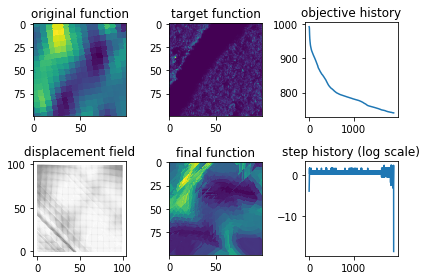

In [74]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(b1_smallf)
ax[0,0].set_title('original function')
ax[0,1].imshow(b2_smallf)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(b1_smallf,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

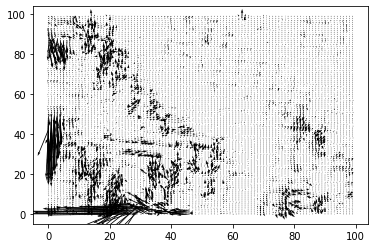

In [70]:
plt.quiver(ux, uy)
plt.show()

On constate ici que l'algorithme qui utilise la méthode de type Newton converge beaucoup plus rapidement (50 itérations) que celui qui utilise la descente de gradient. 

5. Jeu des différences
======================
Maintenant que vous avez implémenté et testé les deux algorithmes sur l'image-jouet proposée, voyons que cela donne sur une image IRM d'un cerveau. Saurez-vous détecter les différences/déplacements entre les deux images ?

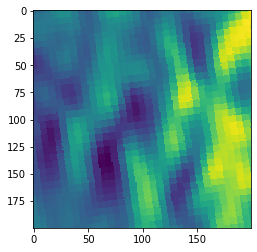

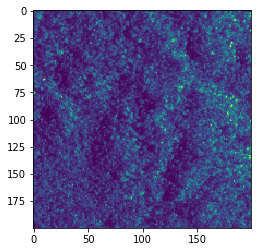

In [13]:
a,b = get_images()
np.shape(a)
plt.imshow(a[1000:1200,500:700])
plt.show()
plt.imshow(b[1000:1200,500:700])
plt.show()
a = a[1000:1200,500:700]
b = b[1000:1200,500:700]

iteration : 10  cost function : 74.13685489083585 step : 10.24
iteration : 20  cost function : 58.83596235232608 step : 2.56
iteration : 30  cost function : 53.524844735160244 step : 2.56
iteration : 40  cost function : 50.3102489605962 step : 2.56
iteration : 50  cost function : 47.95284097705683 step : 2.56


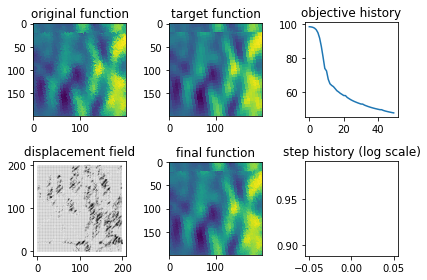

iteration : 60  cost function : 45.93398619616767 step : 2.56
iteration : 70  cost function : 44.49724830441077 step : 2.56
iteration : 80  cost function : 43.37824644245506 step : 2.56
iteration : 90  cost function : 42.27866860149106 step : 2.56
iteration : 100  cost function : 41.44804436011148 step : 2.56


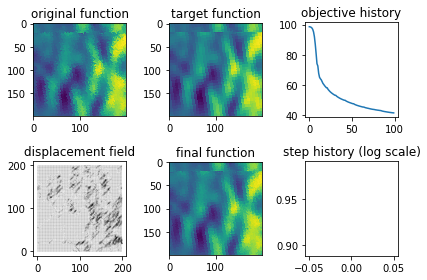

iteration : 110  cost function : 40.835945550267596 step : 2.56
iteration : 120  cost function : 40.1627971362617 step : 2.56
iteration : 130  cost function : 39.51163661442165 step : 2.56
iteration : 140  cost function : 39.02731689582474 step : 2.56
iteration : 150  cost function : 38.52856126016262 step : 2.56


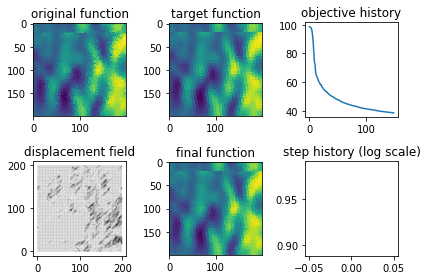

iteration : 160  cost function : 38.196723992672986 step : 2.56
iteration : 170  cost function : 37.75996165822102 step : 2.56
iteration : 180  cost function : 37.471199817232495 step : 2.56
iteration : 190  cost function : 37.140982718886605 step : 2.56
iteration : 200  cost function : 36.94969542016578 step : 2.56


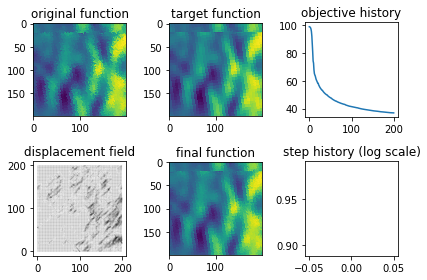

iteration : 210  cost function : 36.661899245783616 step : 2.56
iteration : 220  cost function : 36.421312219195734 step : 2.56
iteration : 230  cost function : 36.13005829089071 step : 2.56
iteration : 240  cost function : 35.94966692762391 step : 2.56


In [92]:
epsi=0.5
nitermax=500
ux,uy,CF,step=RecalageGN(interpol(np.roll(a,5,axis=0),ux_1,uy_1),np.roll(a,5,axis=0),lamb,mu,nitermax,step0,epsi)

In [91]:
ux_1 = np.copy(ux)
uy_1 = np.copy(uy)
Cf_1 = np.copy(CF)
step_1 = np.copy(step)

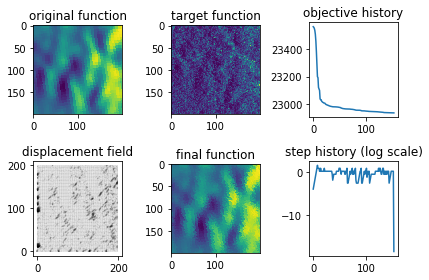

In [73]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(a)
ax[0,0].set_title('original function')
ax[0,1].imshow(b)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(a,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

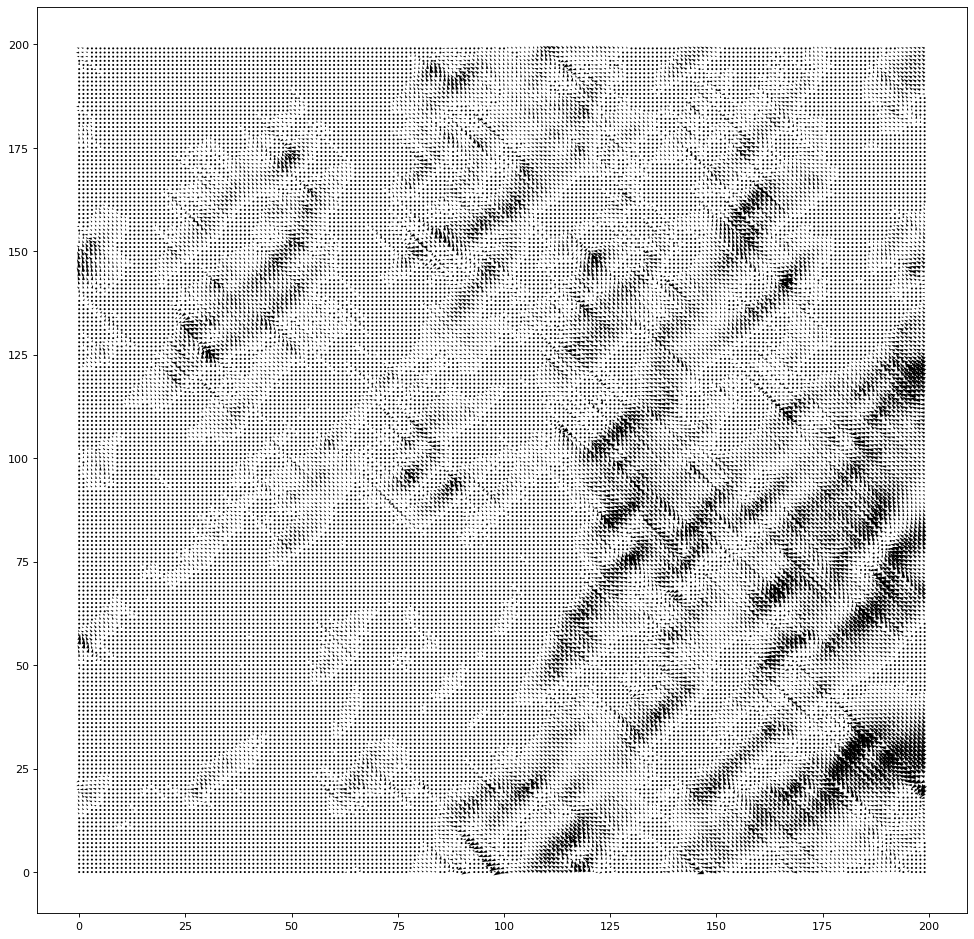

In [93]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
plt.quiver(-ux, uy)
plt.savefig("quiver4.png")
plt.show()

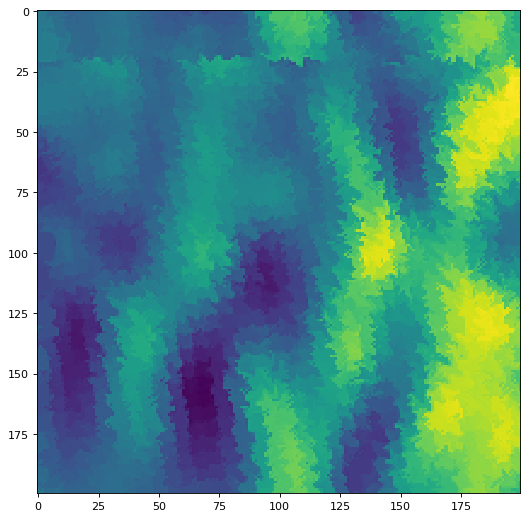

In [94]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(interpol(np.roll(a,20,axis=0),ux_1,uy_1))
plt.savefig("interpol_test_26")

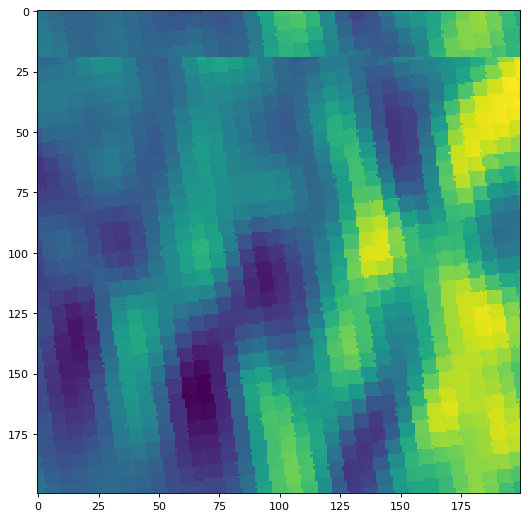

In [95]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(np.roll(a,20,axis=0))
plt.savefig("interpol_test_27")

In [ ]:

epsi=0.1
nitermax=300
lamb = 1/9
ux,uy,CF,step=RecalageDG(f,g,lamb,mu,nitermax,step0)

In [ ]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

In [ ]:
plt.quiver(ux, uy)
plt.show()